In [1]:
import pandas as pd
import numpy as np
from my_ml_package.visualize import plot_digit, plot_cosine_distance, plot_line, plot_data_points
from my_ml_package.distance import euclidean_distance, cosine_distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
# from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

## Distance Metrics

When would we use Distance Metrics?

The most intuitive one
* Euclidean distance: 
    + Generalization: Minkowski distance (Norm 1: Manhattan distance)
    + but can be problematic


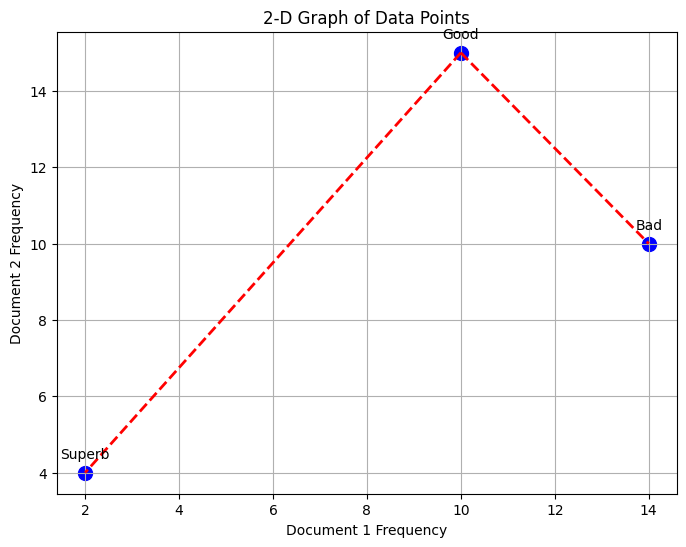

In [6]:
X = np.array([
    [2, 4],  # Superb
    [10, 15],  #  Good
    [14, 10]   # Bad
])

fig, ax = plot_data_points(X, labels= ['Superb', 'Good', 'Bad'])
plot_line( ax, X, 1, 0)  # from Good to Superb
plot_line( ax, X, 1, 2)  # from Good to Bad
plt.show()




Problem 1: Does not count relativity between variables
* Cosine Distance


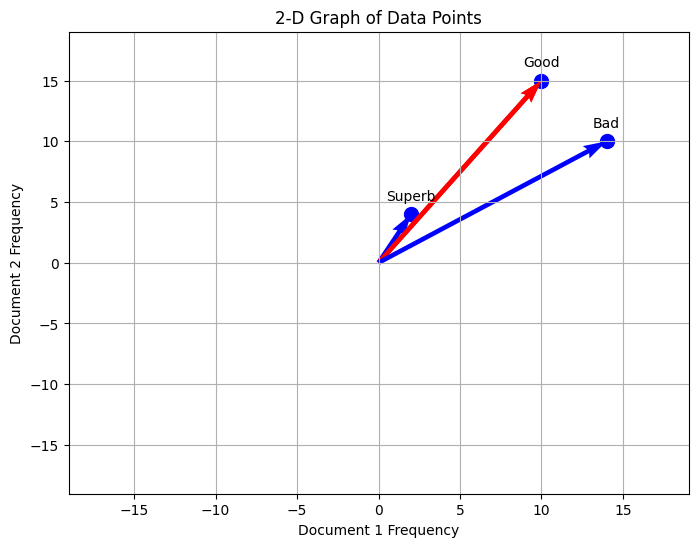

In [8]:
X = np.array([
    [2, 4],  # Superb
    [10, 15],  #  Good
    [14, 10]   # Bad
])

fig, ax = plot_data_points(X, labels= ['Superb', 'Good', 'Bad'])
plot_cosine_distance( ax, X, 1, 0)   # from Good to Superb
plot_cosine_distance( ax, X, 1, 2)  # from Good to Bad
plt.show()

<!-- Problem 2: Variables may correlate with each other.
* Mahalanobis distance -->


Other distance metric:
* Jaccard distance
* Manhattan distance


<!-- To devise a clustering methods, we need to 
* Step 1: define a distance metric between objects $d(x_1, x_2)$
* Step 2: define an objective function (clustering goal)
* Step 3: optimize the objective function by updating parameters -->



When do we need distance metrics?

## K means
The scikit-learn API requies that:
* The data is represented by NumPy array or pandas DataFrame with features in columns and observations in rows.
* The features take on continuous values as opposed to the categories.
* No missing values

In [9]:

# People data with Height cm, Weight kg
X = np.array([
    [175, 75],  # Adult    1
    [60, 5],    # Baby     
    [50, 4],    # Baby     1
    [70, 7],    # Baby     0
    [180, 80],  # Adult    1
    [178, 72],  # Adult (new) 0
    [172, 70],  # Adult (new)  0
    [169, 74],  # Adult (new)  0
    [55, 6],    # Baby (new)  1
    [65, 8]     # Baby (new)  0
])

# True labels
y = ['A', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'B', 'B']

## Generate synthetic dataset with 8 random clusters
model = KMeans(n_clusters=2)
model.fit(X)
y_pred = model.predict(X)

print(y_pred)

[1 0 0 0 1 1 1 1 0 0]


* Steps
  * Initialization 
  * -> Assignment 
  * -> Update <!-- Centroids - Clusters of data points -->
* What are parameters of a K-means model?
* What are hyperparameters of K-means?


In [7]:
def initialize_centroids(X, k):
    """Randomly initialize k centroids from the dataset X."""
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_points_to_centroids(X, centroids):
    """Assign each point in X to the nearest centroid."""
    assignments = []
    for point in X:
        distances = np.sqrt(((point - centroids) ** 2).sum(axis=1))
        closest_centroid = np.argmin(distances)
        assignments.append(closest_centroid)
    return np.array(assignments)

def update_centroids(X, assignments, k):
    """Update centroids to be the mean of points assigned to them."""
    new_centroids = np.array([X[assignments == i].mean(axis=0) for i in range(k)])
    return new_centroids

def k_means(X, k, iterations=100):
    """The K-means algorithm."""
    # Step 1: Initialization
    centroids = initialize_centroids(X, k)
    
    for _ in range(iterations):
        # Step 2: Assignment
        assignments = assign_points_to_centroids(X, centroids)
        
        # Step 3: Update
        new_centroids = update_centroids(X, assignments, k)
        
        # Check for convergence (if centroids do not change)
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return centroids, assignments

def predict(X_new, centroids):
    """
    Assign new data points to the nearest centroid.
    
    Parameters:
    - X_new: numpy array of shape (n_samples, n_features), new data points.
    - centroids: numpy array of shape (k, n_features), the centroids.
    
    Returns:
    - assignments: numpy array of shape (n_samples,), cluster indices for each point.
    """
    assignments = []
    for point in X_new:
        distances = np.sqrt(((point - centroids) ** 2).sum(axis=1))
        closest_centroid = np.argmin(distances)
        assignments.append(closest_centroid)
    return np.array(assignments)


In [8]:
centroids, _ = k_means(X, 2)
predictions = predict(X, centroids)
predictions

array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0])

## K-Mean++

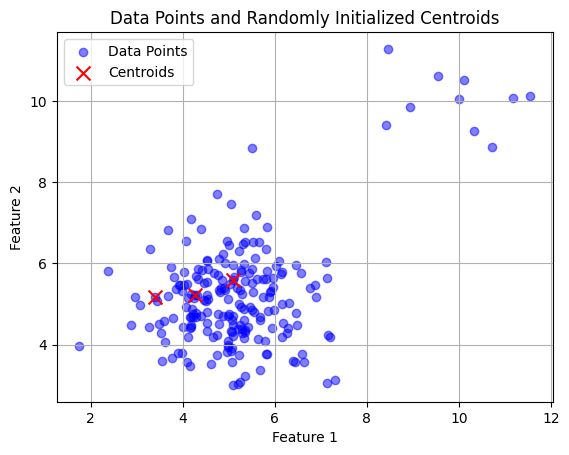

In [31]:
def generate_data_with_dense_cluster(select_centroids_fn, k):
    # Generate a dataset for demonstration if X is not defined
    np.random.seed(42)  # For reproducibility
    dense_cluster = np.random.normal(loc=5, scale=1, size=(200, 2))
    sparse_points = np.random.normal(loc=10, scale=1, size=(10, 2))
    X = np.vstack((dense_cluster, sparse_points))

    # Visualize the centroids along with the data points
    centroids = select_centroids_fn(X, k=k)
    plt.scatter(X[:, 0], X[:, 1], color='blue', alpha=0.5, label='Data Points')
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=100, label='Centroids')
    plt.title("Data Points and Randomly Initialized Centroids")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()
X = generate_data_with_dense_cluster(select_centroids_fn=initialize_centroids, k=3)


In [28]:
def initialize_centroids_plusplus(X, k):
    """Initialize k centroids using the K-means++ algorithm."""
    
    # Step 1: Choose one center uniformly at random from among the data points.
    n_samples, _ = X.shape
    centroids = np.zeros((k, X.shape[1]))
    initial_idx = np.random.choice(n_samples)
    centroids[0] = X[initial_idx]
    
    # Choose the remaining k-1 centers
    for c_id in range(1, k):
        #  Step2: the distance from x to the nearest center
        dist_x_to_c = [np.linalg.norm(X - centroid, axis=1)**2 for centroid in centroids[:c_id]] # shape: (num_c, num_samples)
        distances_to_nc = np.min(dist_x_to_c, axis=0) # shape: (num_samples,)
        # Step 3: Choose one new data point at random as a new center, using a weighted probability distribution 
        # where a point x is chosen with probability proportional to D(x)^2
        probabilities = distances_to_nc / np.sum(distances_to_nc)
        centroid_idx = np.random.choice(n_samples, p=probabilities)
        centroids[c_id] = X[centroid_idx]
    
    return centroids
#         x1, x2, x3, x4, x5, x6, x7, x8, x9, x10
# c1      

## Finding K
Let's determine the hyperparameter K assuming that we do not know that $X$ contains features for 2 digits.
* General idea to use the evaluation metrics?
* What is the Elbow plots?
* How to use the Elbow plot?
<!-- The KElbow plot, indeed, is a type of line chart that is used specifically in the context of k-means clustering (and other k-related clustering algorithms) to help determine the optimal number of clusters (denoted as k). The x-axis represents the number of clusters k, while the y-axis represents the value of a specific metric calculated for the clustering model trained with that given k. The "elbow" in the KElbow plot is the point where the plot bends, indicating a diminishing return in the improvement of the metric value with increasing k, suggesting an optimal k value for clustering. -->

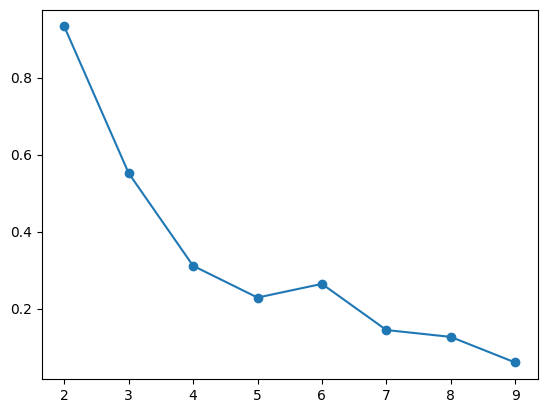

In [46]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
silhouette_scores = []  
for n_clusters in range_n_clusters:
    model = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = model.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range_n_clusters, silhouette_scores, marker='o')


# range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# from my_ml_package.clustering.metrics import calculate_distortion
# scores_over_k = []  
# for n_clusters in range_n_clusters:
#     model = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
#     cluster_labels = model.fit_predict(X)
#     centroids = model.cluster_centers_
#     distortion = calculate_distortion(X.to_numpy(), centroids, cluster_labels)
#     scores_over_k.append(distortion)
# plt.plot(range_n_clusters, scores_over_k, marker='o')


I refer to [this web for silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Another family of clustering algorithms is the visualized clustering, e.g., [VAT, iVAT](https://medium.com/analytics-vidhya/using-visualization-algorithms-vat-ivat-to-assess-cluster-tendency-a89251a2400e#:~:text=iVAT%20is%20a%20visual%20method%20of%20assessing%20the,clearer%20densely%20black%20squares%2Frectangles%20in%20its%20printed%20map.)

In [34]:
# Q4:Now repeat clustering using Kmeans for 50 times and report the average performance.  Again compare the results that you have obtained in Q3 using Kmeans++ and explain the difference (if any).
purity_scores = []
silhouette_scores = []
ari_scores = []
nmi_scores = []
num_iters = 50
for _ in range(num_iters):
    model = KMeans(n_clusters=9, init="random")
    y_pred=model.fit_predict(X)
    purity_scores.append( purity_score(y, y_pred))
    silhouette_scores.append( metrics.silhouette_score(X, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")


silhouette_scores = []
purity_scores = []
ari_scores = []
nmi_scores = []
for _ in range(50): # or use the n_init=50 parameter
    model = KMeans(n_clusters=9, init="k-means++")
    y_pred=model.fit_predict(X)
    
    silhouette_scores.append(metrics.silhouette_score(X, y_pred))
    purity_scores.append( purity_score(y, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")

Purity score: 0.7362565445026178
Silhouette score: 0.19508735589363918
Adjusted Rand index for K-Means performance: 0.6009621580811086
Normalized mutual information for K-Means performance: 0.7354479507136964


In [5]:
# Q4:Now repeat clustering using Kmeans for 50 times and report the average performance.  Again compare the results that you have obtained in Q3 using Kmeans++ and explain the difference (if any).
purity_scores = []
silhouette_scores = []
ari_scores = []
nmi_scores = []
num_iters = 50
for _ in range(num_iters):
    model = KMeans(n_clusters=9, init="random")
    y_pred=model.fit_predict(X)
    purity_scores.append( purity_score(y, y_pred))
    silhouette_scores.append( metrics.silhouette_score(X, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")

Average purity score: 0.7369633507853404
Average silhouette score: 0.19510513701669424
Average adjusted Rand index score for K-Means over 50 runs: 0.6020233877765854
Average normalized mutual information score for K-Means over  ru50ns: 0.7374316529920237


In [6]:
silhouette_scores = []
purity_scores = []
ari_scores = []
nmi_scores = []
for _ in range(50): # or use the n_init=50 parameter
    model = KMeans(n_clusters=9, init="k-means++")
    y_pred=model.fit_predict(X)
    
    silhouette_scores.append(metrics.silhouette_score(X, y_pred))
    purity_scores.append( purity_score(y, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")

Average purity score: 0.738625654450262
Average silhouette score: 0.19476201117696515
Average adjusted Rand index score for K-Means over 50 runs: 0.6042575018050854
Average normalized mutual information score for K-Means over  ru50ns: 0.7384971443241504


In [ ]:
# Q5: Apply DBSCAN on this dataset (digitData2.csv) and find the optimum "eps" and "min_samples" value. 
# Is the number of cluster same as the cluster found in Q2? 
# Explain the similarity or differences that you have found between two solutions. 


Nearest neighbors

In [83]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

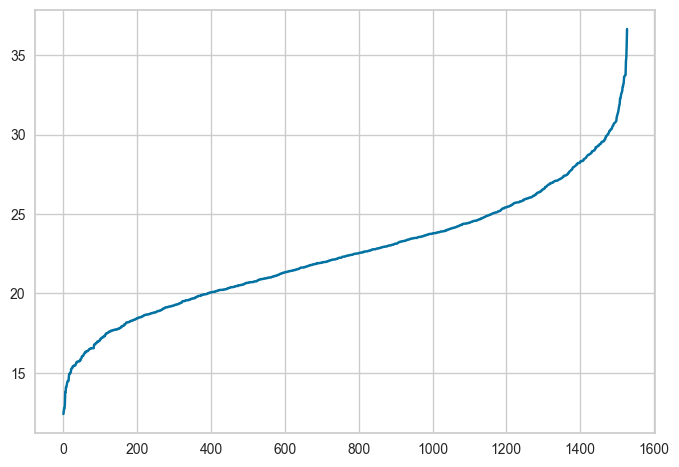

In [108]:
# for all the points, we calculate the distance to the nearest point  
neigh = NearestNeighbors(n_neighbors=9,  algorithm="auto")
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances[:,-1]) 
plt.plot(distances)
plt.show()

# How to choose K?
# K=9
# the submission from Alen Joseph Ben uses KNN to determine n_neighbors
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# k_range = list(range(1, 21))

# cv_scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())
#     print("k = %d, accuracy = %0.3f" % (k, scores.mean()))
# # Print the best value of k
# best_k = k_range[cv_scores.index(max(cv_scores))]
# print("Best k: %d" % best_k)
# # Final evaluation
# final_knn = KNeighborsClassifier(n_neighbors=best_k)
# final_knn.fit(X_train, y_train)
# final_score = final_knn.score(X_val, y_val)
# print(final_score)

In [109]:
distances[30]


15.459624833740307

In [ ]:
# Find optimum min_samples using k-distance graph
# min_samples is the minimum number of points that must be within 'eps' distance of a core point in order for it to be considered as a cluster which is known as the k-distance graph
#The value of k is set to 2 indicating that we are using the second knee point on the elbow plot to determine the value of min_samples
k = 2
k_distance = distances[::-1][k-1]
#Finding 10 nearest neighbors of each data point
neigh = NearestNeighbors(n_neighbors=10)
#Fits the data X to the NearestNeighbors object
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
distances = np.array([d[-1] for d in distances])
distances.sort()
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distances')
plt.title('K-Distance Graph')
plt.show()
#Calculateing the min_samples
min_samples = np.where(distances > k_distance)[0][0]

Why do we select the point at the maximum curvation?

Grid Search

In [94]:
silhouette_scores = []
purity_scores = []
ari_scores = []
nmi_scores = []
df_unique_labels = pd.DataFrame({"eps": [], "min_samples": [], "num_labels": []})

for eps in range(10, 35):
    for min_samples in range(1, 25):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        labelsData = dbscan.labels_
        unique_label_num = len(set(labelsData))
        df_unique_labels = df_unique_labels.append({"eps": eps, "min_samples": min_samples, "num_labels": unique_label_num }, ignore_index=True)
        if unique_label_num > 1 & unique_label_num < len(X):
            # print("labels:", unique_label_num, "eps:", eps, "min_samples:", min_samples)
            try:
                score = metrics.silhouette_score(X, labelsData)
                
            except ValueError:
                raise
            silhouette_scores.append((score, eps, min_samples, unique_label_num,labelsData))
            purity_scores.append( (purity_score(y, y_pred), eps, min_samples, unique_label_num,labelsData) )
            ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
            nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

max_silhouette_score, optimal_eps, optimal_min_samples, optimal_n_label, y_pred = max(silhouette_scores)[:]
print(f"the max silhouette score: {max_silhouette_score}")
print(f"Optimal eps: {optimal_eps}; Optimal min_samples: {optimal_min_samples}; optimal number of cluster: {optimal_n_label}")
print(f"Adjusted Rand index for DBSCAN performance: {metrics.adjusted_rand_score(y, y_pred)}")
print(f"Normalized mutual information for DBSCAN performance: {metrics.normalized_mutual_info_score(y, y_pred)}")
print("the ground truth of labels :", len(set(y)), "the labels_pre: ", len(set(y_pred)))
print("\n")

max_purity_score, optimal_eps, optimal_min_samples, optimal_n_label, y_pred = max(purity_scores)[:]
print(f"the max purity score: {max_silhouette_score}")
print(f"Optimal eps: {optimal_eps}; Optimal min_samples: {optimal_min_samples}; optimal number of cluster: {optimal_n_label}")
print(f"Adjusted Rand index for DBSCAN performance: {metrics.adjusted_rand_score(y, y_pred)}")
print(f"Normalized mutual information for DBSCAN performance: {metrics.normalized_mutual_info_score(y, y_pred)}")
print("the ground truth of labels :", len(set(y)), "the labels_pre: ", len(set(y_pred)))
print("\n")


the max silhouette score: 0.14911176266271708
Optimal eps: 25; Optimal min_samples: 20; optimal number of cluster: 11
Adjusted Rand index for DBSCAN performance: 0.5235916139024015
Normalized mutual information for DBSCAN performance: 0.7165588044491888
the ground truth of labels : 10 the labels_pre:  11


the max purity score: 0.14911176266271708
Optimal eps: 32; Optimal min_samples: 24; optimal number of cluster: 2
Adjusted Rand index for DBSCAN performance: 3.6749544800371906e-05
Normalized mutual information for DBSCAN performance: 0.003995386941039195
the ground truth of labels : 10 the labels_pre:  2




In [110]:
dbscan = DBSCAN(eps=15.459, min_samples=5)
dbscan.fit(X)
labelsData = dbscan.labels_
df_unique_labels = df_unique_labels.append({"eps": eps, "min_samples": min_samples, "num_labels": len(np.unique(labelsData)) }, ignore_index=True)
unique_label_num = len(set(labelsData))
print(labelsData)
if unique_label_num > 1 & unique_label_num < len(X):
    print(metrics.silhouette_score(X, labelsData))
    print(purity_score(y, labelsData))
    n_noise = list(labelsData).count(-1)
    print(f"Number of clusters found by DBSCAN: {unique_label_num}")
    print(f"Number of noise points found by DBSCAN: {n_noise}")
        

[ 0 -1 -1 ... 10 -1 19]
-0.22159583370444244
0.27945026178010474
Number of clusters found by DBSCAN: 22
Number of noise points found by DBSCAN: 1255


In [115]:
dbscan = DBSCAN(eps=32.23, min_samples=X.shape[1] * 2)
dbscan.fit(X)
labelsData = dbscan.labels_
df_unique_labels = df_unique_labels.append({"eps": eps, "min_samples": min_samples, "num_labels": len(np.unique(labelsData)) }, ignore_index=True)
unique_label_num = len(set(labelsData))
print(labelsData)
if unique_label_num > 1 & unique_label_num < len(X):
    print(metrics.silhouette_score(X, labelsData))
    print(purity_score(y, labelsData))
    n_noise = list(labelsData).count(-1)
    print(f"Number of clusters found by DBSCAN: {unique_label_num}")
    print(f"Number of noise points found by DBSCAN: {n_noise}")
        


[ 0 -1 -1 ... -1 -1 -1]
0.0862670152973876
0.2931937172774869
Number of clusters found by DBSCAN: 3
Number of noise points found by DBSCAN: 792


Visualize how epsilon and min_samples affect the resulting number of clusters.

<Axes: xlabel='eps', ylabel='min_samples'>

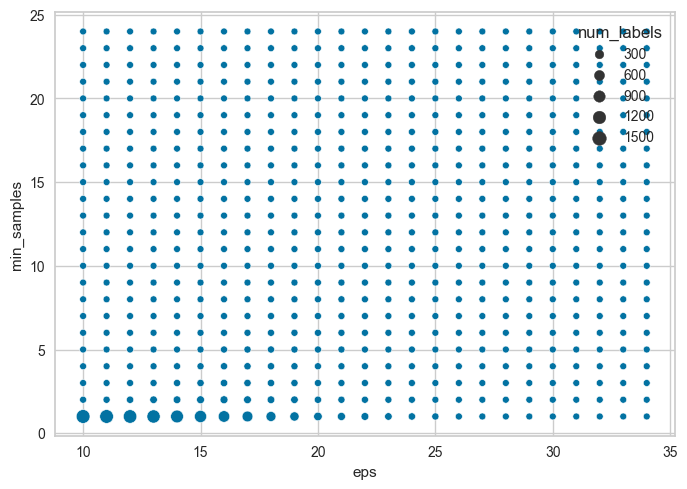

In [89]:
sns.scatterplot(data=df_unique_labels, x="eps", y="min_samples", size="num_labels")